In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


In [2]:
def cart2polar(x, y):
    """For numpy arrays x and y returns the numpy arrays of r and theta.
    """
    r = np.sqrt(x*x + y*y)
    theta = np.rad2deg(np.arctan2(y, x)) #[-180,180]
    #theta0 = np.select([theta<0, theta>=0],[theta+360,theta]) #[0,360]
    return r, theta


def bin_avrg_rad_phi(nda, pb, rb, do_transp=True):
        """Returns 2-d (rad,phi) numpy array of averaged in bin intensity for input array nda."""
        arr_rphi = bin_avrg(_ravel_(nda))[:-1] # -1 removes off ROI bin
        arr_rphi.shape = (pb, rb)
        return np.transpose(arr_rphi) if do_transp else arr_rphi


def bin_avrg(nda, npix_per_bin ):
        """Returns 1-d numpy array of averaged in r-phi bin intensities for input image array nda.
           WARNING array range [0, nrbins*npbins + 1], where +1 bin intensity is for all off ROI pixels.
        """
        num = bin_intensity(_ravel_(nda), iseq, ntbins)
        den = npix_per_bin 
        return divide_protected(num, den, vsub_zero=0)    
    
    
def bin_intensity(nda, iseq, ntbins):
        """Returns 1-d numpy array of total pixel intensity per bin for input array nda."""
        #return np.bincount(self.iseq, weights=self._ravel_(nda), minlength=None)
        return np.bincount(iseq, weights=_ravel_(nda), minlength=ntbins+1) # +1 for overflow bin



def _ravel_(nda):
        if len(np.shape(nda))>1:
            #nda.shape = self.shapeflat
            return nda.ravel() # return ravel copy in order to preserve input array shape
        return nda
   
    
def divide_protected(num, den, vsub_zero=0):
    """Returns result of devision of numpy arrays num/den with substitution of value vsub_zero for zero den elements.
    """
    pro_num = np.select((den!=0,), (num,), default=vsub_zero)
    pro_den = np.select((den!=0,), (den,), default=1)
    return pro_num / pro_den


def polar_histogram(shape, cx, cy, ro, ri, ao, ai, nr, na):
        """Returns hp.HPolar object.
        """
        rows, cols = shape
        xarr1 = np.arange(cols) - cx
        yarr1 = np.arange(rows) - cy
        xarr, yarr = np.meshgrid(xarr1, yarr1)
#         hpolar = hp.HPolar(xarr, yarr, radedges=(ri, ro), nradbins=nr, phiedges=(ao, ai), nphibins=na)
        # logger.info('%s %s\n%s' %(hp.info_ndarr(xarr,'pixel coordinate arrays: xarr'),
        #              hp.info_ndarr(yarr,' yarr'),
        #              hpolar.info_attrs()))
        return xarr, yarr
    
def _set_limit_indexes(self, edgemode):
        """Returns limit bin indexes for underflow and overflow values"""
        if   edgemode==0: return  0, self._nbins-1
        elif edgemode==1: return -1, self._nbins

def bin_indexes(self, arr, edgemode=0):

        indmin, indmax = self._set_limit_indexes(edgemode)

        if self._equalbins:
            factor = float(self._nbins)/(self._edges[-1]-self._edges[0])
            nbins1 = self._nbins-1
            nparr = (np.array(arr, dtype=self._vtype)-self._edges[0])*factor
            ind = np.array(np.floor(nparr), dtype=np.int32)
            return np.select((ind<0, ind>nbins1), (indmin, indmax), default=ind)


# In this notebook, I will create a "fake" set of data to represent a perfect diffraction pattern. I use this data to validate two separate radial profile scripts

Shape of input array is: (100, 100)


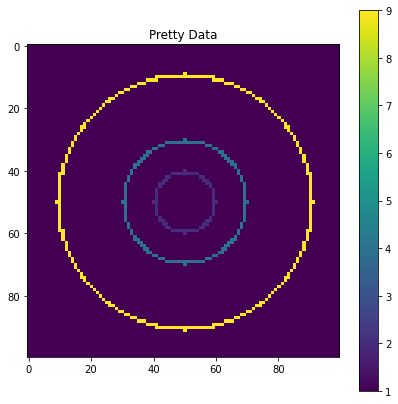

In [5]:
# center point of pattern 
cx = 50
cy = 50

# create empty array 
x = np.linspace(0,0,100)
y = np.linspace(0,0,100)

xx, yy = np.meshgrid(x, y)
arr = xx
arr=(arr+1)

radius = 50

# create rings at radii 10, 20, 40 with increasing intensity
for i in range(len(x)):
    for j in range(len(y)):
        if (np.sqrt((i-cx)**2 + (j-cy)**2) <= 10) & (np.sqrt((i-cx)**2 + (j-cy)**2) >= 9):
            arr[i,j] = 2
        if (np.sqrt((i-cx)**2 + (j-cy)**2) <= 20) & (np.sqrt((i-cx)**2 + (j-cy)**2) >= 19):
            arr[i,j] = 4
        if (np.sqrt((i-cx)**2 + (j-cy)**2) <= 41) & (np.sqrt((i-cx)**2 + (j-cy)**2) >= 40):
            arr[i,j] = 9

# plot "fake" data
print("Shape of input array is:", np.shape(arr))
plt.figure(figsize=(7,7))
plt.imshow(arr)
plt.colorbar()
plt.title("Pretty Data")
plt.show()

# Python Azimuthal Avg Function
This script should be used to plot radial profiles of diffraction patterns. Standard "offline" (aka NOT real time) analysis

Given my set of fake data, we expect peaks at 10, 20, 40 with increasing intensities


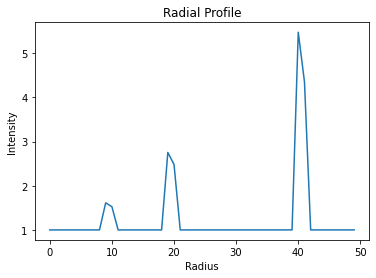

This serves as a validation study for my first azimuthal averaging script


In [9]:
# Image dimensions
num_row = np.shape(arr)[0]
num_col = np.shape(arr)[1]

# For azimuthal average
r_max = 50 # maximum radius to perform azimuthal average (in pixel)

# Center point
x0 = cx
y0 = cy

# Analysis
azi_avg = np.zeros((r_max,))
azi_std = np.zeros((r_max,))
rad_pro = np.zeros((r_max,))
count = np.zeros((r_max,))


for i in range(num_row):
        for j in range(num_col):
            if not np.isnan(arr[i,j]):
                radius = np.sqrt( pow(i-y0,2)+pow(j-x0,2) ) 
                radius_int = int(radius)
                radius_frac = radius - radius_int 
                if radius_int < r_max: 
                    azi_avg[radius_int] += arr[i,j]*(1-radius_frac)
                    count[radius_int] += (1- radius_frac)
                   
                    
                if (radius_int+1) < r_max:
                    azi_avg[radius_int+1] += arr[i,j]*radius_frac
                    count[radius_int+1] += radius_frac
for i in range(r_max):
        if count[i] != 0:
            azi_avg[i] = azi_avg[i] / count[i] 

            
# print/plot results
print("Given my set of fake data, we expect peaks at 10, 20, 40 with increasing intensities")
plt.figure()
plt.plot(azi_avg)
plt.title("Radial Profile")
plt.xlabel("Radius")
plt.ylabel("Intensity")
plt.show()

print("This serves as a validation study for my first azimuthal averaging script")

# AMI Azimuthal Avg Function
This script should be used to plot radial profiles of diffraction patterns. "Online" (aka real time) analysis

In [10]:
# radial parameters
ro = 50
ri = 2
# angular parameters
ao = 0 
ai = 360
# bin parameterz
nr = 50
na = 1

phiedges=(ao,ai)
radedges = (ri, ro)
nradbins = nr
nphibins = na

In [12]:
# create input array

rows, cols = (arr.shape) 
xarr1 = np.arange(cols) - cx
yarr1 = np.arange(rows) - cy
xarr, yarr = np.meshgrid(xarr1, yarr1)

print("The shape of input array = ",np.shape(arr))
print(xarr)

The shape of input array =  (100, 100)
[[-50 -49 -48 ...  47  48  49]
 [-50 -49 -48 ...  47  48  49]
 [-50 -49 -48 ...  47  48  49]
 ...
 [-50 -49 -48 ...  47  48  49]
 [-50 -49 -48 ...  47  48  49]
 [-50 -49 -48 ...  47  48  49]]


In [14]:
rad, phi0 = cart2polar(xarr, yarr)
print("Rad is an array of radii; the radius of every point in meshgrid, shape =")
print(rad.shape)
print('flatten rad array')
shapeflat = (rad.size,)
rad.shape = shapeflat
phi0.shape = shapeflat
print(rad.shape)
print("Max radius = ",rad.max())
# phi = 1-d numpy array of pixel angules in the range [phi_min, phi_min+360] degree 
phimin = min(phiedges[0], phiedges[-1])
phi = np.select((phi0 < phimin, phi0 >= phimin), (phi0+360.,phi0))
print('\n')
print('Phi is an array of angles in the range of [0, 360]')
print("phi max = ",phi.max()) # why only 90?

Rad is an array of radii; the radius of every point in meshgrid, shape =
(100, 100)
flatten rad array
(10000,)
Max radius =  70.71067811865476


Phi is an array of angles in the range of [0, 360]
phi max =  358.83086067209257


In [16]:
# Binning: radial(rad), angular(phi), total
nrbins = nr
npbins = na
ntbins = npbins*nrbins # total number of bins in r-phi array

print("Total radial bins = ", nr)
print("Total angular bins = ", na)
print("Total bins = ", ntbins) # nt will be x axis, make sure it = the desireed range
print("\n")

#  Create a 1-d numpy array of pixel radial indexes [-1,nrbins] called irad
indmin, indmax = (-1, nr)
factor = float(nr)/(radedges[-1]-radedges[0])
print("radial factor = ",factor)
nbins1 = nr-1
nparr = (np.array(rad, dtype=np.float32)-radedges[0])*factor
ind = np.array(np.floor(nparr), dtype=np.int32)
irad = np.select((ind<0, ind>nbins1), (indmin, indmax), default=ind)

# Create a 1-d numpy array of pixel angular indexes [-1,npbins] called iphi
indmin, indmax = (-1, na)
factor = float(na)/(phiedges[-1]-phiedges[0])
print("angular factor = ",factor)
nbins1 = na-1
nparr = (np.array(phi, dtype=np.float32)-phiedges[0])*factor
ind = np.array(np.floor(nparr), dtype=np.int32)
iphi = np.select((ind<0, ind>nbins1), (indmin, indmax), default=ind)



Total radial bins =  50
Total angular bins =  1
Total bins =  50


radial factor =  1.0416666666666667
angular factor =  0.002777777777777778


In [17]:
cond = np.logical_and(\
               np.logical_and(irad > -1, irad < nrbins),
               np.logical_and(iphi > -1, iphi < npbins)
               )

# iseq is the array of sequentially (in rad and phi) numerated pixel indexes [0,ntbins]
iseq = np.select((cond,), (iphi*nrbins + irad,), ntbins).ravel()
npix_per_bin = np.bincount(iseq, weights=None, minlength=ntbins+1)

# num is the array of total pixel intensity per bin for input array 
num = bin_intensity((arr.ravel()), iseq, ntbins)

# den is an array of the number of accounted pixels per bin
den = npix_per_bin
arr_rphi = divide_protected(num, den, vsub_zero=0)

In [21]:
# divide the total pixel intensity by number of pixels per bin
arr_final = divide_protected(num, den, vsub_zero=0)[:-1]
arr_final.shape = (npbins, nrbins)
arr_final = np.transpose(arr_final)

rproj = np.sum(arr_final, axis=1)/npbins



Shape of radial profile array =  (50,)
Dimensions of radial profile array =  1


Expect peaks at 9, 19, 40 with increasing intensities


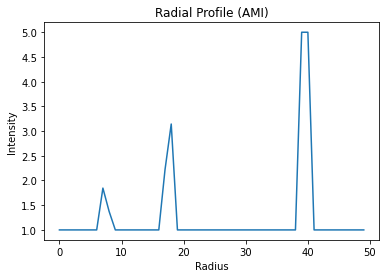

this acts as a validation study for my second azimuthal averaging script


In [23]:
print("Shape of radial profile array = ", np.shape(rproj))
print("Dimensions of radial profile array = ", (arr_rphi.ndim))
print("\n")
print("Expect peaks at 9, 19, 40 with increasing intensities")

plt.figure()
plt.plot(rproj)
plt.title("Radial Profile (AMI)")
plt.xlabel("Radius")
plt.ylabel("Intensity")
plt.show()

print("this acts as a validation study for my second azimuthal averaging script")